# Example 1: Product purity based material screening

## Libraries and data import

In [5]:
from simulator import *
from calculator import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('240219_Casestudy1_data_rev.csv', index_col=0)

## Membrane property calculation

In [6]:
# Sizing parameters
D_inner = 100*1e-1            # Membrane inner diameter (mm)
D_outer = 250*1e-1            # Membrane outer diameter (mm)
thickness = (D_outer-D_inner)/2

q_list = []
a_i = []
p_i = []
for ii in range(len(data)):
    target_mof = data.iloc[ii,:]
    pp_H2, DD_H2,qq_H2  = target_mof[['P_H2(bar)', 'D_H2(m^2/s)','q_H2(mol/kg)']].values
    pp_N2, DD_N2,qq_N2  = target_mof[['P_N2(bar)', 'D_N2(m^2/s)','q_N2(mol/kg)']].values
    rho = target_mof['Density(kg ads/m^3)']

    a_H2 = CalculPermeance(pp_H2, DD_H2*1e6, qq_H2, rho*1e-9, thickness)
    a_N2 = CalculPermeance(pp_N2, DD_N2*1e6, qq_N2, rho*1e-9, thickness)
    
    a_i.append([a_H2, a_N2])
    p_i.append([a_H2*thickness/(3.4e-14), a_N2*thickness/(3.4e-14)])        # Permeability (Barrer)

data[['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']] = np.array(a_i)
data[['P_H2(Barrer)', 'P_N2(Barrer)']] = np.array(p_i)

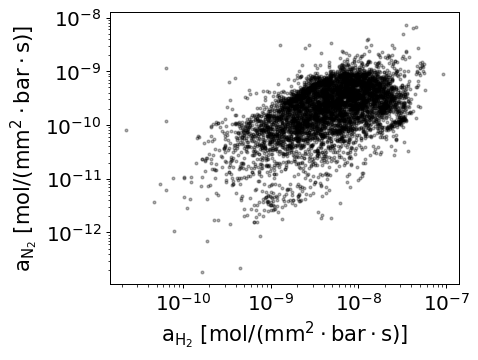

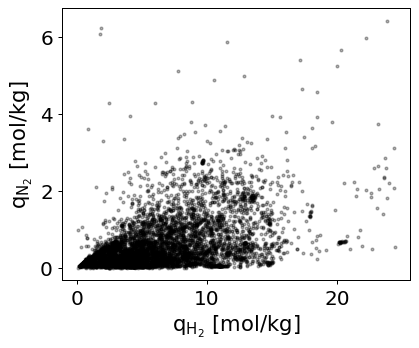

In [8]:
plt.figure(dpi=90, figsize=(5,4))
plt.scatter(data['a_H2(mol/(mm^2 bar s))'], data['a_N2(mol/(mm^2 bar s))'], 
            c='k', alpha=0.3, s=5)
plt.ylabel('a$_{\mathrm{N_2}}$ [$\mathrm{mol/(mm^2\cdot bar\cdot s)}$]')
plt.xlabel('a$_{\mathrm{H_2}}$ [$\mathrm{mol/(mm^2\cdot bar\cdot s)}$]')
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.figure(dpi=90, figsize=(5,4))
plt.scatter(data['q_H2(mol/kg)'], data['q_N2(mol/kg)'], 
            c='k', alpha=0.3, s=5)
plt.ylabel('q$_{\mathrm{N_2}}$ [mol/kg]')
plt.xlabel('q$_{\mathrm{H_2}}$ [mol/kg]')
plt.show()


## Membrane process simulation

In [9]:
### Parameter input ###
### Module design ###
n_component = 2               # number of gas components
config = 'COFS'               # module configuration
L = 0.6*1e3                   # fiber length (mm)
D_module = 0.3*1e3            # Module diameter (mm)
N_fiber = 100                 # number of fiber (-)
N = 100                       # number of nodes (-)

### Membrane property ###
D_inner = 100*1e-1            # Membrane inner diameter (mm)
D_outer = 250*1e-1            # Membrane outer diameter (mm)

### Gas property ###
Mw_i = np.array([2e-3, 28e-3])                 # molar weight (kg/mol)
rho_i = np.array([0.08988, 1.1606])*1e-9       # density (kg/mm3)
mu_i = np.array([0.94e-3, 1.89e-3])            # viscosity (Pa s)

### Mass transfer property ###
k_mass = 1e-1              # Mass transfer coeff. (mm/s)

### Operating conditions ###
# Boundary conditions
P_feed = 20                         # pressure of feed side (bar)
T = 273                             # temperature (K)
F_feed = 0.7                        # feed flow rate (mol/s)
y_feed = np.array([0.75, 0.25])     # mole fraction (H2, N2)

In [11]:
pu_list = []
for ii in range(len(data)):
    target_mof = data.iloc[ii,:]
    a_perm = np.array([target_mof[ii] for ii in ['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']])
    mem = MembraneProc(config, L, D_module, N_fiber, 
                n_component, n_node = N)
    mem.membrane_info(a_perm, D_inner, D_outer)
    mem.gas_prop_info(Mw_i, mu_i, rho_i)
    mem.mass_trans_info(k_mass)
    mem.boundaryC_info(y_feed, P_feed, F_feed, T)
    mem.initialC_info()

    res = mem.run_mem(cp=False, cp_cond = [1, 298])
    err = mem.MassBalance()

    F_perm = res[-1, n_component:n_component*2]

    F_ret = res[-1, :n_component]
    F_perm[F_ret<0] = (F_feed*y_feed)[F_ret<0]
    F_ret[F_ret<0] = 0
    
    pu_ = [flow[0]/sum(flow) if sum(flow)>0 else 0 for flow in [F_ret, F_perm]]
    pu_list.append(pu_)
data[[f'Pu_ret_{F_feed}', f'Pu_perm_{F_feed}']] = np.array(pu_list)
# data.to_csv('240219_Casestudy1_results.csv')

Simulation started
Simulation is completed without warning
Mass balance (error %):  4.7429492145568846e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.5815202136296615e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.157974888320352e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.731326047517825e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.16689201772538e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.581437086407023e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.573508477134565e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.585491050827731e-14
Simulation started
Simulation is completed without warning
Mass

## Results analysis

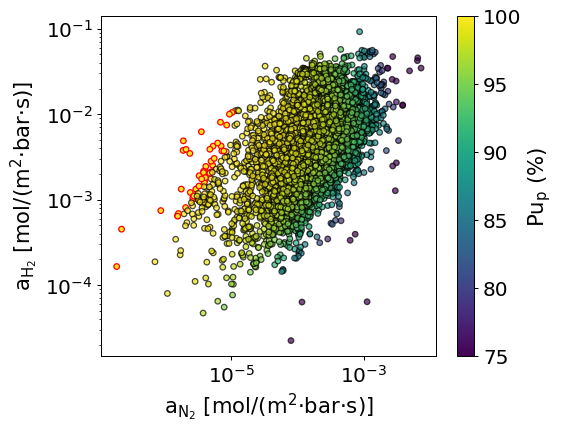

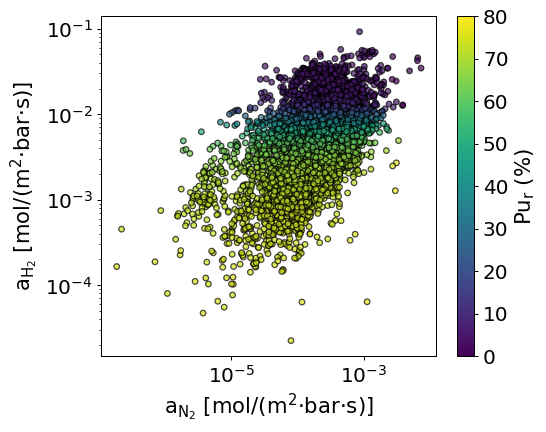

In [16]:
ex1_res = pd.read_csv('240219_Casestudy1_results.csv')
pot_MOF = ex1_res[(ex1_res[f'Pu_ret_{F_feed}'] > 0.999) |(ex1_res[f'Pu_perm_{F_feed}'] > 0.999)]

plt.figure(dpi=90, figsize=(6,5))
plt.scatter(ex1_res['a_N2(mol/(mm^2 bar s))']*1e6, ex1_res['a_H2(mol/(mm^2 bar s))']*1e6, 
            c=ex1_res[f'Pu_perm_{F_feed}']*100,  
            edgecolors=['k' if targ<=0.999 else 'r' for targ in ex1_res[f'Pu_perm_{F_feed}']], 
            alpha=[0.7 if targ<=0.999 else 1 for targ in ex1_res[f'Pu_perm_{F_feed}']],
            s=20,vmin=75, vmax=100
            )
plt.colorbar(label='Pu$_{\mathrm{p}}$ (%)')
plt.ylabel('a$_{\mathrm{H_2}}$ [$\mathrm{mol/(m^{2}·bar·s)}$]')
plt.xlabel('a$_{\mathrm{N_2}}$ [$\mathrm{mol/(m^{2}·bar·s)}$]')
plt.yscale('log')
plt.xscale('log')
plt.show()

plt.figure(dpi=90, figsize=(6,5))
plt.scatter(ex1_res['a_N2(mol/(mm^2 bar s))']*1e6, ex1_res['a_H2(mol/(mm^2 bar s))']*1e6, 
            c=ex1_res[f'Pu_ret_{F_feed}']*100,  
            edgecolors=['k' if targ<=0.999 else 'r' for targ in ex1_res[f'Pu_ret_{F_feed}']], 
            alpha=[0.7 if targ<=0.999 else 1 for targ in ex1_res[f'Pu_ret_{F_feed}']],
            s=20,
            vmin=0, vmax=80
            )
plt.colorbar(label='Pu$_{\mathrm{r}}$ (%)')
plt.ylabel('a$_{\mathrm{H_2}}$ [$\mathrm{mol/(m^{2}·bar·s)}$]')
plt.xlabel('a$_{\mathrm{N_2}}$ [$\mathrm{mol/(m^{2}·bar·s)}$]')
plt.yscale('log')
plt.xscale('log')
plt.show()

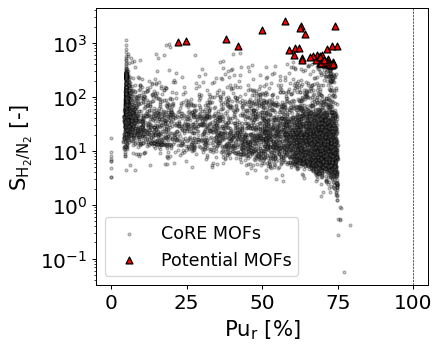

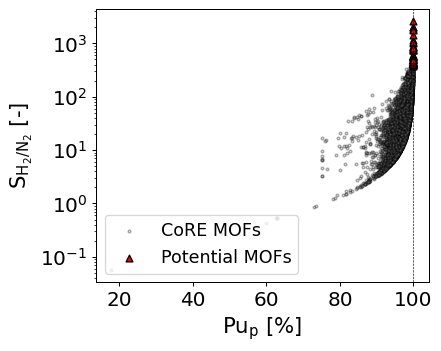

In [21]:
ex1_res['S_H/N'] = ex1_res['a_H2(mol/(mm^2 bar s))']/ex1_res['a_N2(mol/(mm^2 bar s))']
pu_max = (ex1_res[['Pu_ret_0.7', 'Pu_perm_0.7']]).max(axis=1)

plt.figure(dpi=90, figsize=(5,4))
plt.scatter(ex1_res['Pu_ret_0.7'][pu_max<=0.999]*100, ex1_res['S_H/N'][pu_max<=0.999],
            c='grey', alpha=0.3, edgecolors='k',
            s = 5, label='CoRE MOFs',)
plt.scatter(ex1_res['Pu_ret_0.7'][pu_max>0.999]*100, ex1_res['S_H/N'][pu_max>0.999],
            c='r', alpha=1, s=30,
            edgecolors='k', label='Potential MOFs',
            marker='^')
plt.axvline(99.9, c='k', linestyle='--', linewidth = 0.5)
plt.legend(fontsize=14)
plt.xlabel('Pu$\mathrm{_{r}}$ [%]')
plt.ylabel('S$\mathrm{_{H_2/N_2}}$ [-]')
plt.yscale('log')
plt.tight_layout()
plt.show()


plt.figure(dpi=90, figsize=(5,4))
plt.scatter(ex1_res['Pu_perm_0.7'][pu_max<=0.999]*100, ex1_res['S_H/N'][pu_max<=0.999],
            c='grey', alpha=0.3, edgecolors='k',
            s = 5, label='CoRE MOFs',)
plt.scatter(ex1_res['Pu_perm_0.7'][pu_max>0.999]*100, ex1_res['S_H/N'][pu_max>0.999],
            c='r', alpha=1, s=30,
            edgecolors='k', label='Potential MOFs',
            marker='^')
plt.axvline(99.9, c='k', linestyle='--', linewidth = 0.5)
plt.xlabel('Pu$\mathrm{_{p}}$ [%]')
plt.ylabel('S$\mathrm{_{H_2/N_2}}$ [-]')
plt.yscale('log')
plt.legend(fontsize=14, loc='lower left')
plt.tight_layout()
plt.show()

# Example 2: Rigorous evaluation (TEA)

## Libraries and data import

In [5]:
from simulator import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import differential_evolution

data = pd.read_csv('240219_Casestudy1_results.csv')
pot_MOF = data[data['Pu_perm_0.7']>0.999]
pot_MOF.describe()

,Unnamed: 0,D_H2(m^2/s),D_N2(m^2/s),P_H2(bar),P_N2(bar),q_H2(mol/kg),q_N2(mol/kg),Density(kg ads/m^3),a_H2(mol/(mm^2 bar s)),a_N2(mol/(mm^2 bar s)),P_H2(Barrer),P_N2(Barrer),Pu_ret_0.7,Pu_perm_0.7
count,47.000000,4.700000e+01,4.700000e+01,47.0,47.0,47.000000,47.000000,47.000000,4.700000e+01,4.700000e+01,4.700000e+01,47.000000,47.000000,47.000000
mean,3306.808511,1.567298e-08,3.777830e-09,6.0,2.0,4.805661,0.016175,1676.279796,2.818864e-09,3.990963e-12,6.218082e+05,880.359436,0.650174,0.999256
std,1948.323545,1.252213e-08,4.491508e-09,0.0,0.0,1.393742,0.009786,211.361403,2.354532e-09,2.276909e-12,5.193821e+05,502.259240,0.117028,0.000237
min,115.000000,1.530000e-09,6.740000e-10,6.0,2.0,1.580498,0.000827,1223.172226,1.651723e-10,1.863339e-13,3.643507e+04,41.103069,0.220962,0.999002
25%,1714.500000,8.525000e-09,1.126500e-09,6.0,2.0,4.142893,0.007666,1578.291494,1.272552e-09,2.393949e-12,2.807100e+05,528.077048,0.629322,0.999071
50%,3982.000000,1.110000e-08,1.740000e-09,6.0,2.0,4.777535,0.015520,1631.975494,2.042608e-09,3.823700e-12,4.505753e+05,843.463274,0.693318,0.999178
75%,5070.000000,1.925000e-08,4.270000e-09,6.0,2.0,5.384183,0.021359,1766.157594,3.744903e-09,5.017576e-12,8.260815e+05,1106.818257,0.716855,0.999350
max,5855.000000,6.900000e-08,1.590000e-08,6.0,2.0,8.874532,0.040910,2247.855828,1.047468e-08,1.027440e-11,2.310591e+06,2266.411377,0.746063,0.999821


## Parameter input

In [2]:
### Parameter input ###
### Module design ###
n_component = 2               # number of gas components
configuration = 'COFS'               # module configuration
L = 0.6*1e3                   # fiber length (mm)
D_module = 0.3*1e3            # Module diameter (mm)
N_fiber = 100                 # number of fiber (-)
N = 100                       # number of nodes (-)

### Membrane property ###
D_inner = 100*1e-1            # Membrane inner diameter (mm)
D_outer = 250*1e-1            # Membrane outer diameter (mm)

### Gas property ###
Mw_i = np.array([2e-3, 28e-3])                 # molar weight (kg/mol)
rho_i = np.array([0.08988, 1.1606])*1e-9       # density (kg/mm3)
mu_i = np.array([0.94e-3, 1.89e-3])            # viscosity (Pa s)

### Mass transfer property ###
k_mass = 1e-1              # Mass transfer coeff. (mm/s)

### Operating conditions ###
# Boundary conditions
P_feed = 20                         # pressure of feed side (bar)
T = 273                             # temperature (K)
F_feed = 0.7                        # feed flow rate (mol/s)
y_feed = np.array([0.75, 0.25])     # mole fraction (H2, N2)

In [3]:
# Economic analysis parameters
MODP = 10/1000000       # Total membrane module cost (US$/ft2)
mem_life = 4           # membrane life (years)
t = 5              # project year
r = 0.1             # interest rate (%)
R_gas = 8.314 # Gas constant (J/K mol)
k = 1.4       # Heat capacity ratio
effi_ref = 0.8     # compressor efficiency

## Production cost optimization

In [7]:
def ObjFunc(x):
    ff, pf, ll, D_m = x[0], x[1], x[2], x[3]
    
    mem = MembraneProc(configuration, ll, D_m, N_fiber, 
                       n_component, n_node = N)
    mem.membrane_info(a_perm, D_inner, D_outer)
    mem.gas_prop_info(Mw_i, mu_i, rho_i)
    mem.mass_trans_info(k_mass)
    mem.boundaryC_info(y_feed, pf, ff, T)           
    mem.initialC_info()
    res = mem.run_mem(cp=False, cp_cond = [1, 298])

    F_perm = res[-1, n_component:n_component*2]
    F_ret = res[-1, :n_component]

    F_perm[F_ret<0] = (F_feed*y_feed)[F_ret<0]
    F_ret[F_ret<0] = 0
    pu_list = [flow[0]/sum(flow) if sum(flow)>0 else 0 for flow in [F_ret, F_perm]]
    
    if max(pu_list) >= 0.999:
        penalty = abs(max(pu_list)-0.999)**2
        lcoh = mem.CalculTAC(MODP, mem_life, t, r, k, effi_ref)/(F_perm[0]*28800000*1e-3)
                # USD / kmol H2
        return lcoh+penalty
    
    else:   
        lcoh = 1e30
        penalty = max(pu_list)
        return lcoh/penalty

In [8]:
bounds = [(0.05,1),(10,30),(L/6, L), (D_module/1.1, D_module*2)]

proc_cond = []
mssg_list = []
lcoh_list = []

for ii in range(len(pot_MOF)):
    target_mof = pot_MOF.iloc[ii,:]
    a_perm = np.array([target_mof[ii] for ii in ['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']])
    result = differential_evolution(ObjFunc, bounds=bounds,
                                maxiter = 50, tol = 1e-2)
    proc_cond.append(result.x)
    mssg_list.append(result['message'])
    lcoh_list.append(result.fun)

pot_MOF[['Ff_opt', 'Pf_opt', 'L_opt', 'D_opt']] = np.array(proc_cond)
pot_MOF['LCOH_opt'] = lcoh_list

pot_MOF.to_csv('240221_Casestudy2_results.csv', index=0)

Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warni

## Results analysis

In [11]:
ex2_res = pd.read_csv('240221_Casestudy2_results.csv')
lcoh_list = []
pu_list = []
for ii in range(len(ex2_res)):
    target_mof = ex2_res.iloc[ii,:]
    ff_opt, pf_opt, l_opt, dm_opt = target_mof[['Ff_opt', 'Pf_opt', 'L_opt', 'D_opt']]
    a_perm = np.array([target_mof[ii] for ii in ['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']])
    mem = MembraneProc(configuration, l_opt, dm_opt, N_fiber, 
                       n_component, n_node = N)
    mem.membrane_info(a_perm, D_inner, D_outer)
    mem.gas_prop_info(Mw_i, mu_i, rho_i)
    mem.mass_trans_info(k_mass)
    mem.boundaryC_info(y_feed, pf_opt, ff_opt, T)           
    mem.initialC_info()
    res = mem.run_mem(cp=False, cp_cond = [1, 298])

    F_perm = res[-1, n_component:n_component*2]
    F_ret = res[-1, :n_component]
    F_perm[F_ret<0] = (ff_opt*y_feed)[F_ret<0]
    F_ret[F_ret<0] = 0
    
    pu_ = [flow[0]/sum(flow) if sum(flow)>0 else 0 for flow in [F_ret, F_perm]]
    pu_list.append(pu_)
    LCOH = mem.CalculTAC(MODP, mem_life, t, r, k, effi_ref)/(F_perm[0]*28800000*1e-3)
    lcoh_list.append(LCOH)
ex2_res[['Pu_ret_opt','Pu_perm_opt']] = np.array(pu_list)

Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warni

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_4420\813404753.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=ads_names, rotation=90, fontsize=14)


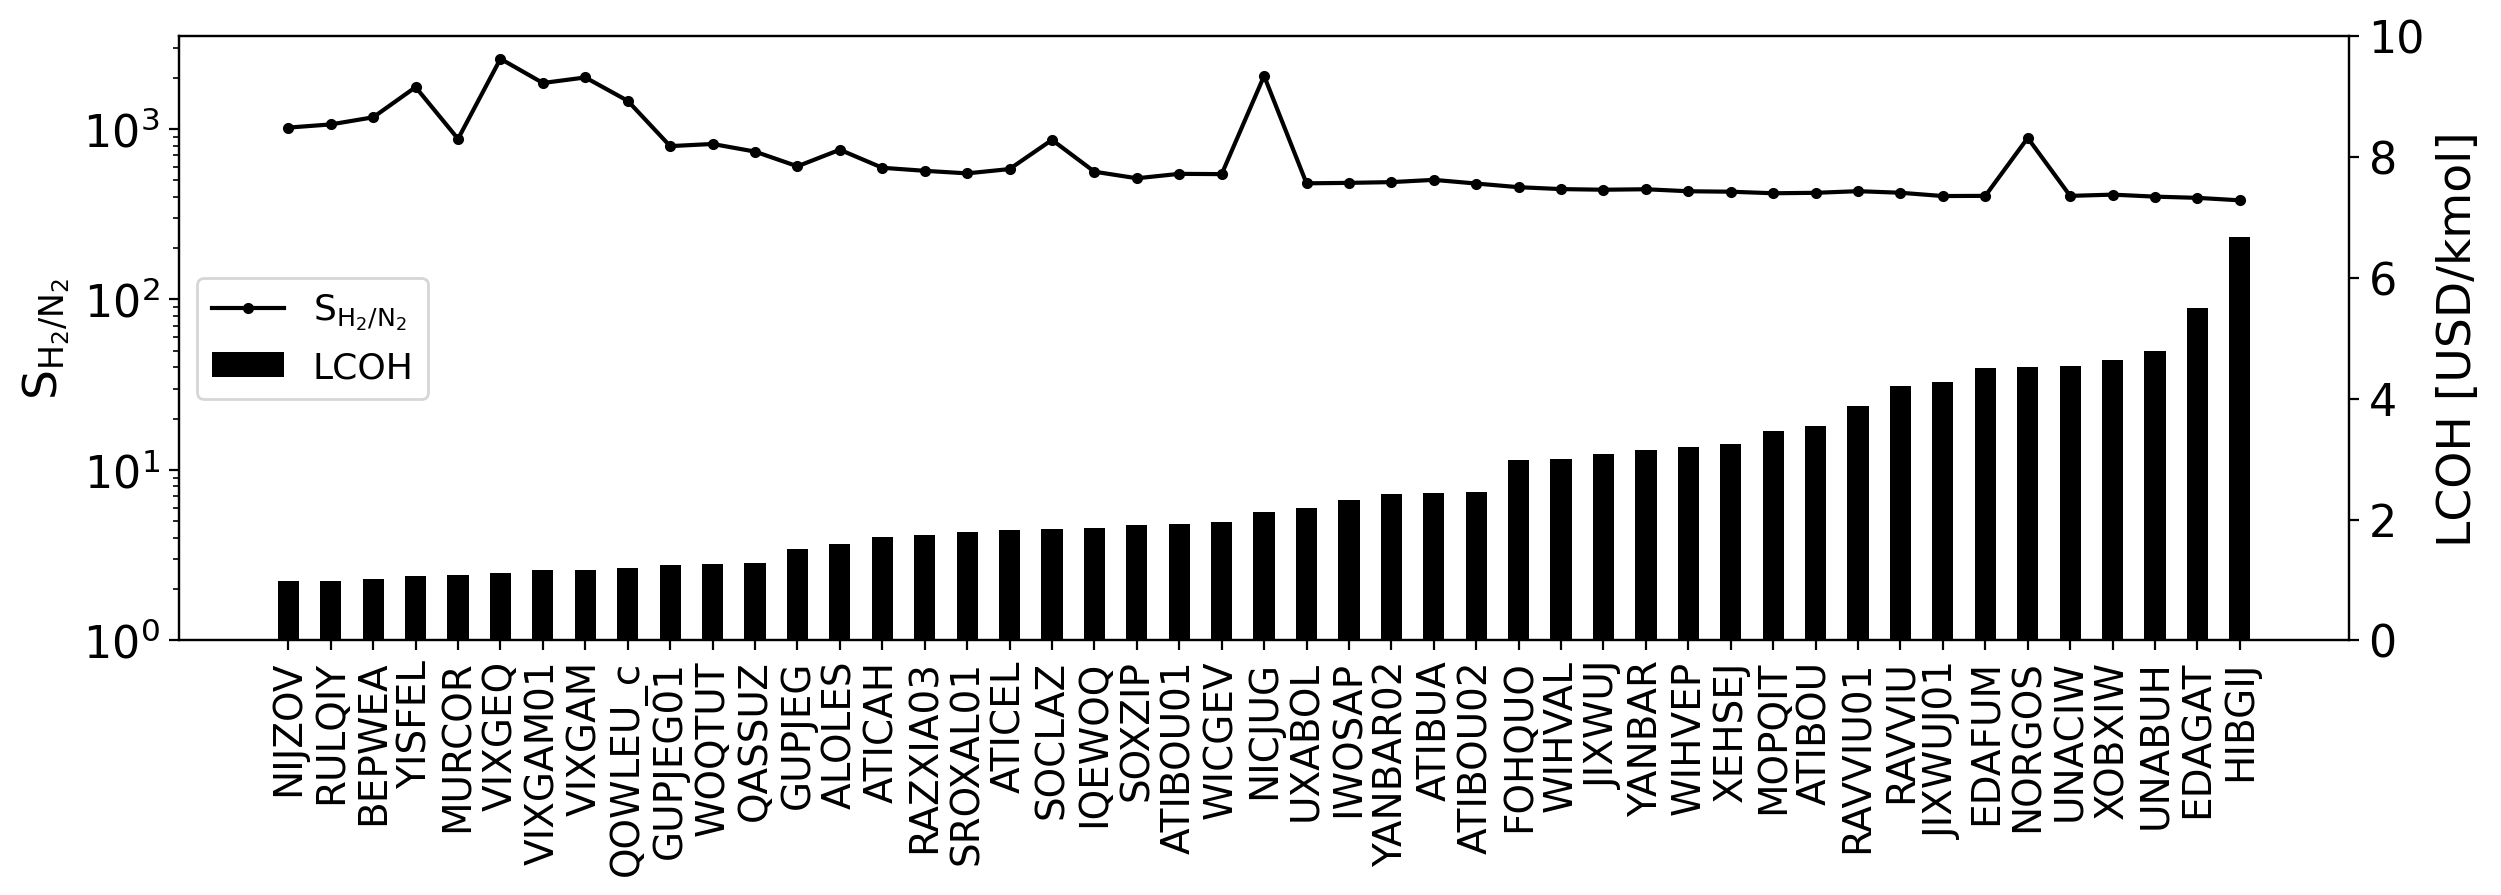

In [12]:
opt_sort = ex2_res.sort_values(by='LCOH_opt')#.iloc[:25]

ads_names = [_name[:-6] for _name in opt_sort['Adsorbent']]
fig, ax1 = plt.subplots(dpi=200, figsize=(14,4))
line = ax1.plot(ads_names, opt_sort['P_H2(Barrer)']/opt_sort['P_N2(Barrer)'],
         color='k', marker='o', label ='S$\mathrm{_{H_2/N_2}}$', markersize=3)
ax2 = ax1.twinx()
bar = ax2.bar(ads_names,opt_sort['LCOH_opt'],
        color='k', width=0.5, label='LCOH')

plots = line+ [bar]
labels = [l.get_label() for l in plots]
ax1.legend(plots, labels, loc='center left', fontsize=13)
ax1.set_yscale('log')
ax1.set_ylim(1,3.5e3)
ax2.set_ylim(0,10)
ax1.set_xticklabels(labels=ads_names, rotation=90, fontsize=14)
ax1.set_ylabel('S$\mathrm{_{H_2/N_2}}$')
ax2.set_ylabel('LCOH [USD/kmol]')
plt.show()

## Sensitivity analysis

In [13]:
rr_list = [0.7, 0.85, 1, 1.15, 1.3]
rr_case = []
for ii in range(len(rr_list)*4):
    _tmp = [1,1,1]
    insert_idx, ratio_idx= divmod(ii,len(rr_list))
    _tmp.insert(insert_idx,rr_list[ratio_idx])
    rr_case.append(_tmp)

In [14]:
var_name = ['Feed flowrate', 'Feed pressure', 'Module length', 'Module diameter']
x_labels = ['-30%', '-15%', 'Original', '+15%', '+30%']
c_list = ['g', 'r', 'b', 'k']

best_mof = opt_sort.iloc[0,:]
sa_res = []
for f_fac, p_fac, l_fac, d_fac in rr_case:
    F_feed, P_feed, L, Dm = best_mof['Ff_opt']*f_fac, best_mof['Pf_opt']*p_fac, best_mof['L_opt']*l_fac, best_mof['D_opt']*d_fac
    a_H2, a_N2 = best_mof[['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']]
    a_perm = np.array([a_H2, a_N2])
    
    mem = MembraneProc(configuration, L, Dm, N_fiber, 
                    n_component, n_node = N)
    mem.membrane_info(a_perm, D_inner, D_outer)
    mem.gas_prop_info(Mw_i, mu_i, rho_i)
    mem.mass_trans_info(k_mass)
    mem.boundaryC_info(y_feed, P_feed, F_feed, T)           
    mem.initialC_info()
    res = mem.run_mem(cp=False, cp_cond = [1, 298])
    err = mem.MassBalance()
    
    F_perm = res[-1, n_component:n_component*2]
    F_ret = res[-1, :n_component]
    F_perm[F_ret<0] = (F_feed*y_feed)[F_ret<0]
    F_ret[F_ret<0] = 0
    
    lcoh = mem.CalculTAC(MODP, mem_life, t, r, k, effi_ref)/(F_perm[0]*28800000*1e-3)
    sa_res.append([F_feed,P_feed, L, Dm, res[-1,0], res[-1,1], res[-1,2], res[-1,3], err, lcoh])
sens_lcoh = np.array(sa_res)

Simulation started
Simulation is completed without warning
Mass balance (error %):  3.5320240954652383e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.965152507062365e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  5.763906716005093e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  2.5518781745176038e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.321122168653189e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.3156028090695713e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.965152507062365e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.652309337193439e-14
Simulation started
Simulation is completed without warning
Ma

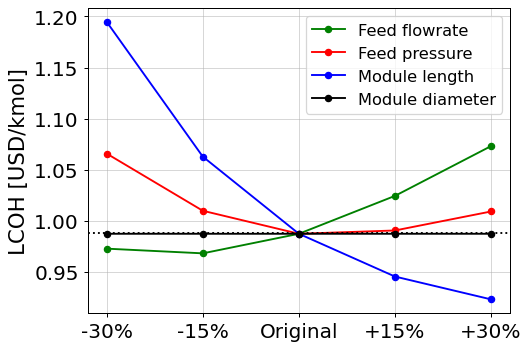

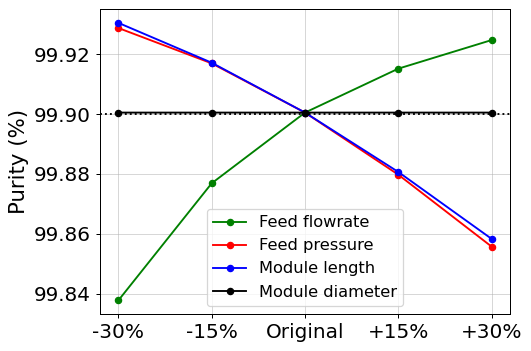

In [15]:
plt.figure(dpi=90, figsize=(6,4))
for ii in range(4):
    res_plot = np.array(sens_lcoh[ii*5:(ii+1)*5, -1])
    plt.plot(x_labels, res_plot, label = var_name[ii], marker='o', c=c_list[ii],
            markersize=5)
plt.axhline(best_mof['LCOH_opt'], c='k', linestyle=':')
plt.legend(loc='best', fontsize=13)
plt.ylabel('LCOH [USD/kmol]')
plt.tight_layout()
plt.grid(alpha=0.5)
plt.show()

plt.figure(dpi=90, figsize=(6,4))
for ii in range(4):
    res_plot = np.array(sens_lcoh[ii*5:(ii+1)*5,:])
    purity_plot = res_plot[:,6]/(res_plot[:,6]+res_plot[:,7])*100
    plt.plot(x_labels, purity_plot, label = var_name[ii], marker='o', c=c_list[ii],
            markersize=5)
plt.axhline(99.9, c='k', linestyle=':')
plt.legend(loc='best', fontsize=13)
plt.ylabel('Purity (%)')
plt.tight_layout()
plt.grid(alpha=0.5)
plt.show()

In [16]:
#### Module length ####
rr_list = [0.7, 0.85, 1, 1.15, 1.3]

sens_lll = []
for ii in range(len(opt_sort)):
    mof = opt_sort.iloc[ii,:]
    for l_fac in rr_list:
        F_feed, P_feed, L, Dm = mof['Ff_opt'], mof['Pf_opt'], mof['L_opt']*l_fac, mof['D_opt']
        a_H2, a_N2 = mof[['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']]
        a_perm = np.array([a_H2, a_N2])
        
        mem = MembraneProc(configuration, L, Dm, N_fiber, 
                        n_component, n_node = N)
        mem.membrane_info(a_perm, D_inner, D_outer)
        mem.gas_prop_info(Mw_i, mu_i, rho_i)
        mem.mass_trans_info(k_mass)
        mem.boundaryC_info(y_feed, P_feed, F_feed, T)           
        mem.initialC_info()
        res = mem.run_mem(cp=False, cp_cond = [1, 298])
        
        F_perm = res[-1, n_component:n_component*2]
        F_ret = res[-1, :n_component]
        F_perm[F_ret<0] = (F_feed*y_feed)[F_ret<0]
        F_ret[F_ret<0] = 0
    
        lcoh = mem.CalculTAC(MODP, mem_life, t, r, k, effi_ref)/(F_perm[0]*28800000*1e-3)
        sens_lll.append([F_feed,P_feed, L, Dm, res[-1,0], res[-1,1], res[-1,2], res[-1,3], lcoh])

Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warni

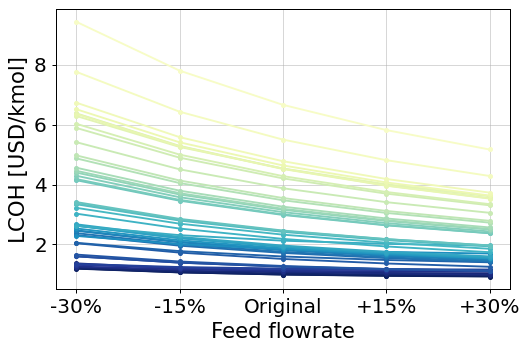

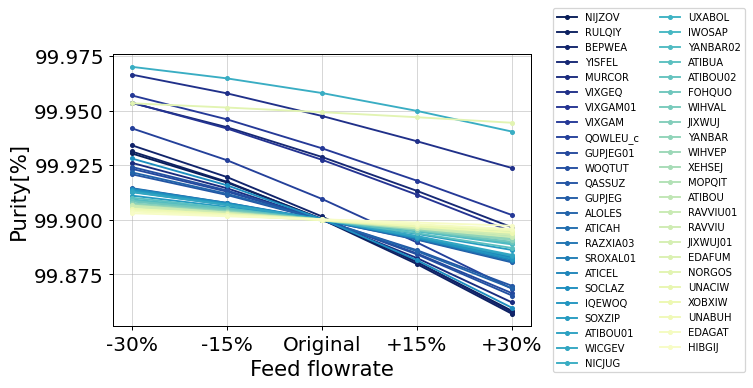

In [17]:
cmap_case = plt.get_cmap('YlGnBu_r')
num_colors = len(opt_sort)+3
colors = cmap_case(np.linspace(0, 1, num_colors))[:len(opt_sort)]

var_name = ['Feed flowrate', 'Feed pressure', 'Module length', 'Module diameter']
x_labels = ['-30%', '-15%', 'Original', '+15%', '+30%']

plt.figure(dpi=90, figsize=(6,4))
c_list = ['k', 'r', 'b', 'g']
for ii in range(len(opt_sort)):
    res_plot = np.array(sens_lll)[ii*5:(ii+1)*5, -1]
    plt.plot(x_labels, res_plot, label = f'{ads_names[ii]} (Top {ii+1})', marker='o',
             c=colors[ii],
             markersize=3)
plt.grid(alpha=0.5)
plt.ylabel('LCOH [USD/kmol]')
plt.xlabel('Feed flowrate')
plt.tight_layout()
plt.show()

plt.figure(dpi=90, figsize=(6,4))
c_list = ['k', 'r', 'b', 'g']
for ii in range(len(opt_sort)):
    res_plot = np.array(sens_lll)[ii*5:(ii+1)*5, :]
    purity_plot = res_plot[:,6]/(res_plot[:,6]+res_plot[:,7])*100
    plt.plot(x_labels, purity_plot, label = ads_names[ii], marker='o',
             c=colors[ii], 
             markersize=3)
plt.legend(loc='center left', bbox_to_anchor=(1.04,0.5), fontsize=8, ncol=2)
plt.ylabel('Purity[%]')
plt.xlabel('Feed flowrate')
plt.grid(alpha=.5)
plt.show()

In [18]:
#### Feed flow rate ####
rr_list = [0.7, 0.85, 1, 1.15, 1.3]

sens_fff = []
for ii in range(len(opt_sort)):
    mof = opt_sort.iloc[ii,:]
    for f_fac in rr_list:
        F_feed, P_feed, L, Dm = mof['Ff_opt']*f_fac, mof['Pf_opt'], mof['L_opt'], mof['D_opt']
        a_H2, a_N2 = mof[['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']]
        a_perm = np.array([a_H2, a_N2])
        
        mem = MembraneProc(configuration, L, Dm, N_fiber, 
                        n_component, n_node = N)
        mem.membrane_info(a_perm, D_inner, D_outer)
        mem.gas_prop_info(Mw_i, mu_i, rho_i)
        mem.mass_trans_info(k_mass)
        mem.boundaryC_info(y_feed, P_feed, F_feed, T)           
        mem.initialC_info()
        res = mem.run_mem(cp=False, cp_cond = [1, 298])
        err = mem.MassBalance()
        
        F_perm = res[-1, n_component:n_component*2]
        F_ret = res[-1, :n_component]
        F_perm[F_ret<0] = (F_feed*y_feed)[F_ret<0]
        F_ret[F_ret<0] = 0
    
        lcoh = mem.CalculTAC(MODP, mem_life, t, r, k, effi_ref)/(F_perm[0]*28800000*1e-3)
        sens_fff.append([F_feed,P_feed, L, Dm, res[-1,0], res[-1,1], res[-1,2], res[-1,3], lcoh])

Simulation started
Simulation is completed without warning
Mass balance (error %):  3.5320240954652383e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.965152507062365e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  5.763906716005093e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  2.5518781745176038e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  2.110777233225535e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.5649029069783206e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.15716083703

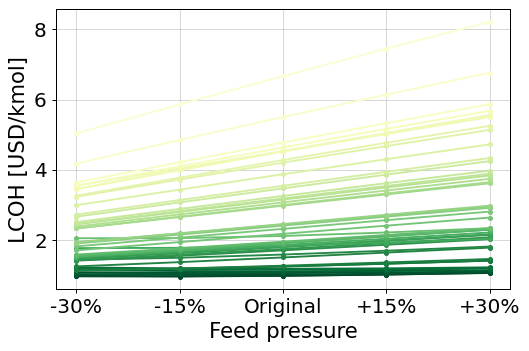

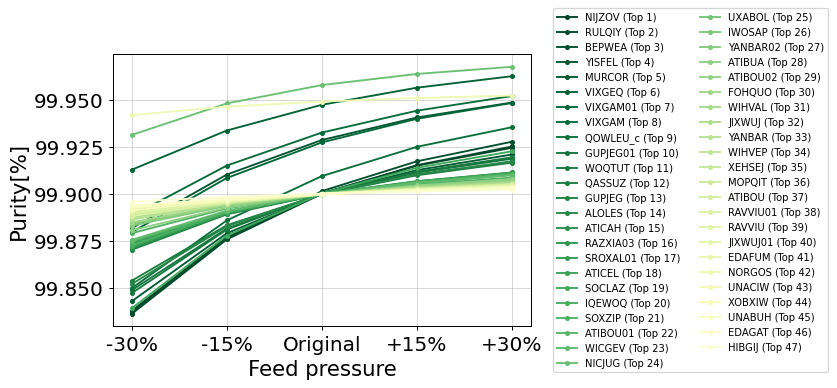

In [26]:
cmap_case = plt.get_cmap('YlGn_r')
num_colors = len(opt_sort)+3
colors = cmap_case(np.linspace(0, 1, num_colors))[:len(opt_sort)]

var_name = ['Feed flowrate', 'Feed pressure', 'Module length', 'Module diameter']
x_labels = ['-30%', '-15%', 'Original', '+15%', '+30%']

plt.figure(dpi=90, figsize=(6,4))
c_list = ['k', 'r', 'b', 'g']
for ii in range(len(opt_sort)):
    res_plot = np.array(sens_fff)[ii*5:(ii+1)*5, -1]
    plt.plot(x_labels, res_plot, label = ads_names[ii], marker='o',
             c=colors[ii],
             markersize=3)
plt.grid(alpha=0.5)
plt.ylabel('LCOH [USD/kmol]')
plt.xlabel('Feed pressure')
plt.tight_layout()
plt.show()

plt.figure(dpi=90, figsize=(6,4))
c_list = ['k', 'r', 'b', 'g']
for ii in range(len(opt_sort)):
    res_plot = np.array(sens_fff)[ii*5:(ii+1)*5, :]
    purity_plot = res_plot[:,6]/(res_plot[:,6]+res_plot[:,7])*100
    plt.plot(x_labels, purity_plot, label = f'{ads_names[ii]} (Top {ii+1})', marker='o',
             c=colors[ii], 
             markersize=3)
plt.legend(loc='center left', bbox_to_anchor=(1.04,0.5), fontsize=8, ncol=2)
plt.ylabel('Purity[%]')
plt.xlabel('Feed pressure')
plt.grid(alpha=.5)
plt.show()

In [20]:
#### Feed pressure ####
rr_list = [0.7, 0.85, 1, 1.15, 1.3]

sens_ppp = []
for ii in range(len(opt_sort)):
    target = opt_sort.iloc[ii,:]
    for p_fac in rr_list:
        F_feed, P_feed, L, Dm = target['Ff_opt'], target['Pf_opt']*p_fac, target['L_opt'], target['D_opt']
        a_H2, a_N2 = target[['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']]
        a_perm = np.array([a_H2, a_N2])
        
        mem = MembraneProc(configuration, L, Dm, N_fiber, 
                        n_component, n_node = N)
        mem.membrane_info(a_perm, D_inner, D_outer)
        mem.gas_prop_info(Mw_i, mu_i, rho_i)
        mem.mass_trans_info(k_mass)
        mem.boundaryC_info(y_feed, P_feed, F_feed, T)           
        mem.initialC_info()
        res = mem.run_mem(cp=False, cp_cond = [1, 298])
        err = mem.MassBalance()
        
        F_perm = res[-1, n_component:n_component*2]
        F_ret = res[-1, :n_component]
        F_perm[F_ret<0] = (F_feed*y_feed)[F_ret<0]
        F_ret[F_ret<0] = 0
    
        lcoh = mem.CalculTAC(MODP, mem_life, t, r, k, effi_ref)/(F_perm[0]*28800000*1e-3)
        sens_ppp.append([F_feed,P_feed, L, Dm, res[-1,0], res[-1,1], res[-1,2], res[-1,3], lcoh])

Simulation started
Simulation is completed without warning
Mass balance (error %):  3.321122168653189e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.3156028090695713e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.965152507062365e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.652309337193439e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  6.598307476778455e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  5.4105159900869817e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.600800965712212e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.5884452023738214e-14
Simulation started
Simulation is completed without warning
Ma

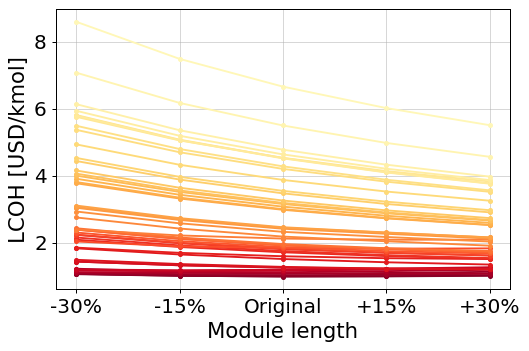

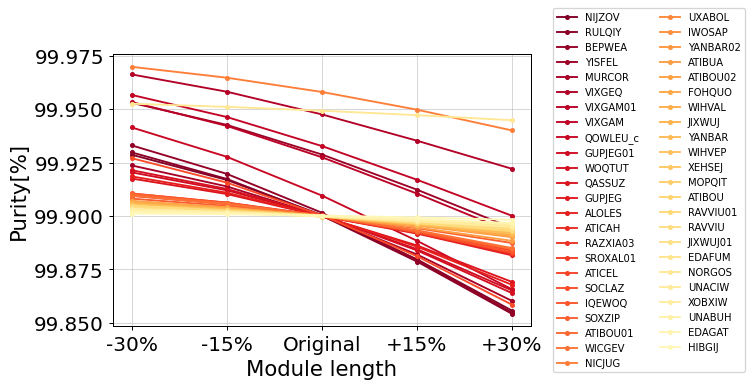

In [21]:
cmap_case = plt.get_cmap('YlOrRd_r')
num_colors = len(opt_sort)+3
colors = cmap_case(np.linspace(0, 1, num_colors))[:len(opt_sort)]

x_labels = ['-30%', '-15%', 'Original', '+15%', '+30%']

plt.figure(dpi=90, figsize=(6,4))
c_list = ['k', 'r', 'b', 'g']
for ii in range(len(opt_sort)):
    res_plot = np.array(sens_ppp)[ii*5:(ii+1)*5, -1]
    plt.plot(x_labels, res_plot, label = ads_names[ii], marker='o',
             c=colors[ii],
             markersize=3)
plt.grid(alpha=0.5)
plt.ylabel('LCOH [USD/kmol]')
plt.xlabel('Module length')
plt.tight_layout()
plt.show()

plt.figure(dpi=90, figsize=(6,4))
c_list = ['k', 'r', 'b', 'g']
for ii in range(len(opt_sort)):
    res_plot = np.array(sens_ppp)[ii*5:(ii+1)*5, :]
    purity_plot = res_plot[:,6]/(res_plot[:,6]+res_plot[:,7])*100
    plt.plot(x_labels, purity_plot, label = ads_names[ii], marker='o',
             c=colors[ii], 
             markersize=3)
plt.legend(loc='center left', bbox_to_anchor=(1.04,0.5), fontsize=8, ncol=2)
plt.ylabel('Purity[%]')
plt.xlabel('Module length')
plt.grid(alpha=.5)
plt.show()

In [22]:
#### Module diameter ####
rr_list = [0.7, 0.85, 1, 1.15, 1.3]

sens_ddd = []
for ii in range(len(opt_sort)):
    target = opt_sort.iloc[ii,:]
    for d_fac in rr_list:
        F_feed, P_feed, L, Dm = target['Ff_opt'], target['Pf_opt'], target['L_opt'], target['D_opt']*d_fac
        a_H2, a_N2 = target[['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']]
        a_perm = np.array([a_H2, a_N2])
        
        mem = MembraneProc(configuration, L, Dm, N_fiber, 
                        n_component, n_node = N)
        mem.membrane_info(a_perm, D_inner, D_outer)
        mem.gas_prop_info(Mw_i, mu_i, rho_i)
        mem.mass_trans_info(k_mass)
        mem.boundaryC_info(y_feed, P_feed, F_feed, T)           
        mem.initialC_info()
        res = mem.run_mem(cp=False, cp_cond = [1, 298])
        err = mem.MassBalance()
        
        F_perm = res[-1, n_component:n_component*2]
        F_ret = res[-1, :n_component]
        F_perm[F_ret<0] = (F_feed*y_feed)[F_ret<0]
        F_ret[F_ret<0] = 0
    
        lcoh = mem.CalculTAC(MODP, mem_life, t, r, k, effi_ref)/(F_perm[0]*28800000*1e-3)
        sens_ddd.append([F_feed,P_feed, L, Dm, res[-1,0], res[-1,1], res[-1,2], res[-1,3], lcoh])

Simulation started
Simulation is completed without warning
Mass balance (error %):  1.6550508356869705e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.965152507062226e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  4.965152507062365e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.3101016713749356e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.5946125123798e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  5.3919187686762785e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  7.1892250249017

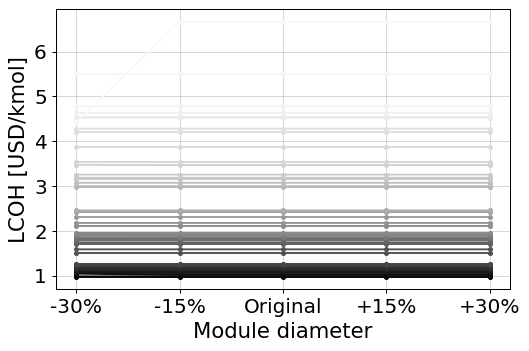

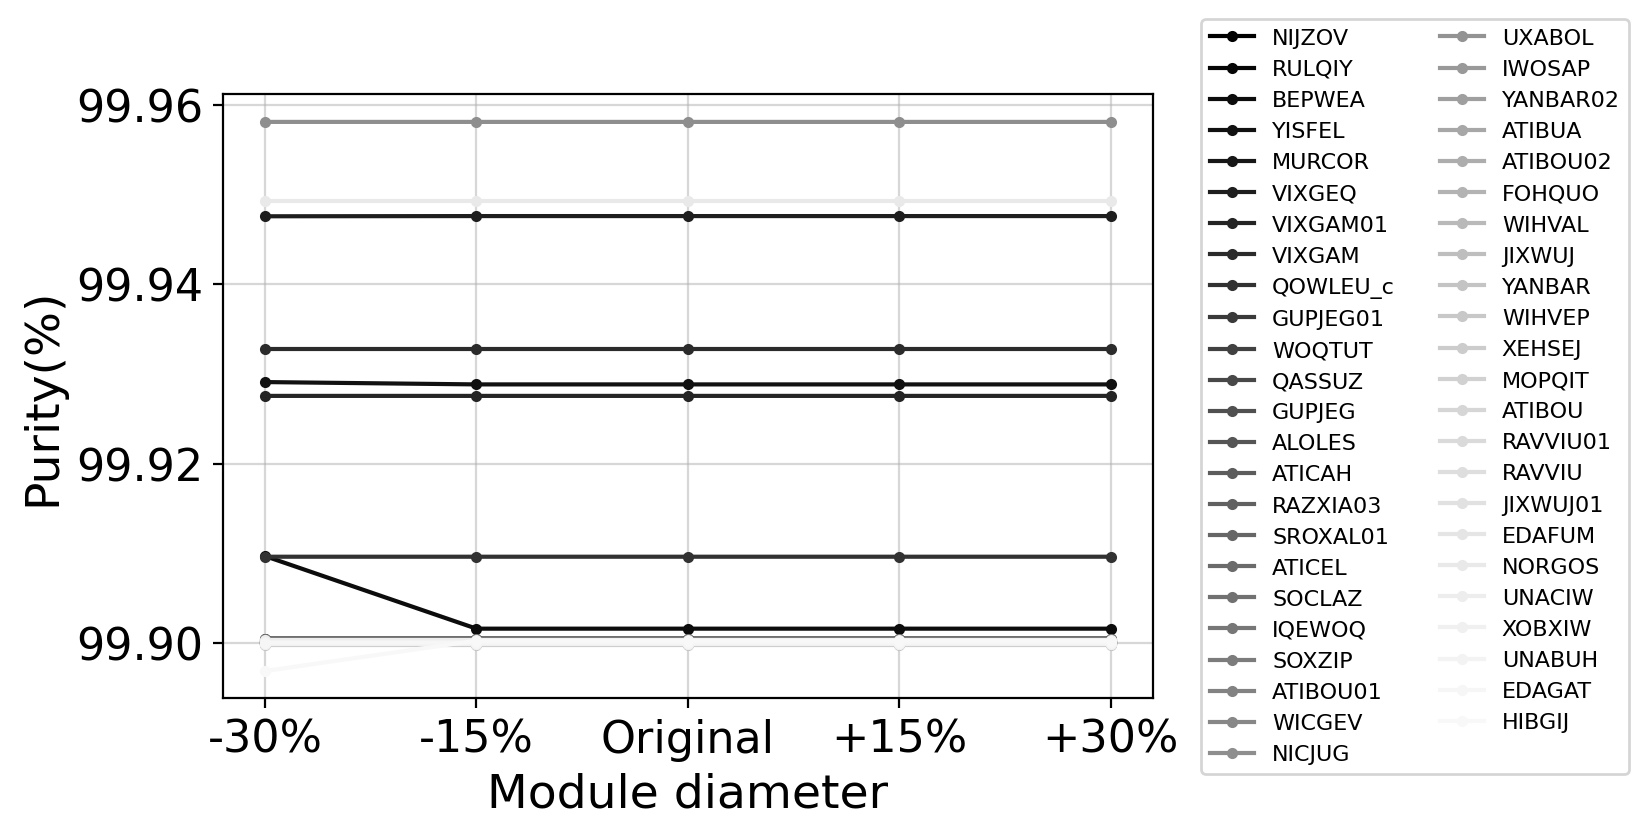

In [27]:
cmap_case = plt.get_cmap('Greys_r')
num_colors = len(opt_sort)+3
colors = cmap_case(np.linspace(0, 1, num_colors))[:len(opt_sort)]

x_labels = ['-30%', '-15%', 'Original', '+15%', '+30%']

plt.figure(dpi=90, figsize=(6,4))
c_list = ['k', 'r', 'b', 'g']
for ii in range(len(opt_sort)):
    res_plot = np.array(sens_ddd)[ii*5:(ii+1)*5, -1]
    plt.plot(x_labels, res_plot, label = ads_names[ii], marker='o',
             c=colors[ii],
             markersize=3)
plt.grid(alpha=0.5)
plt.ylabel('LCOH [USD/kmol]')
plt.xlabel('Module diameter')
plt.tight_layout()
plt.show()

plt.figure(dpi=200, figsize=(6,4))
c_list = ['k', 'r', 'b', 'g']
for ii in range(len(opt_sort)):
    res_plot = np.array(sens_ddd)[ii*5:(ii+1)*5, :]
    purity_plot = res_plot[:,6]/(res_plot[:,6]+res_plot[:,7])*100
    plt.plot(x_labels, purity_plot, label = ads_names[ii], marker='o',
             c=colors[ii], 
             markersize=3)
plt.legend(loc='center left', bbox_to_anchor=(1.04,0.5), fontsize=8, ncol=2)
plt.ylabel('Purity(%)')
plt.xlabel('Module diameter')
plt.grid(alpha=.5)
plt.show()

In [24]:
PL_fes = []
best_mof = opt_sort.iloc[0,:]
for Lmm in range(1, 7):
    for Pff in range(5,16):
        a_H2, a_N2 = best_mof[['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']]
        a_perm = np.array([a_H2, a_N2])
        
        mem = MembraneProc(configuration, Lmm*1e2, D_module, N_fiber, 
                        n_component, n_node = N)
        mem.membrane_info(a_perm, D_inner, D_outer)
        mem.gas_prop_info(Mw_i, mu_i, rho_i)
        mem.mass_trans_info(k_mass)
        mem.boundaryC_info(y_feed, Pff, best_mof['Ff_opt'], T)           
        mem.initialC_info()
        res = mem.run_mem(cp=False, cp_cond = [1, 298])
        err = mem.MassBalance()
        
        F_perm = res[-1, n_component:n_component*2]
        F_ret = res[-1, :n_component]
        F_perm[F_ret<0] = (F_feed*y_feed)[F_ret<0]
        F_ret[F_ret<0] = 0
    
        lcoh = mem.CalculTAC(MODP, mem_life, t, r, k, effi_ref)/(F_perm[0]*28800000*1e-3)
        PL_fes.append([F_feed,Pff, L, Dm, res[-1,0], res[-1,1], res[-1,2], res[-1,3], err, lcoh])


Simulation started
Simulation is completed without warning
Mass balance (error %):  3.3398627435687754e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.6693099962423586e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.66899947794557e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  5.006067221731107e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.6683787844969692e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.668068609893171e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  5.0032756505766714e-14
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.667448605433357e-14
Simulation started
Simulation is completed without warning
Ma

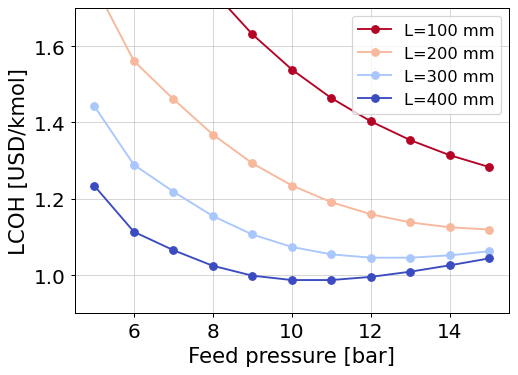

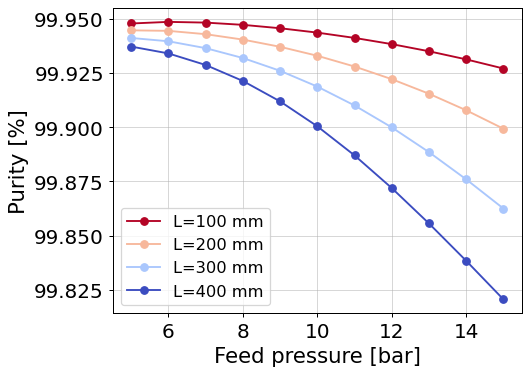

In [25]:
plt.figure(dpi=90, figsize=(6,4))
coolwarm_cmap = plt.get_cmap('coolwarm_r')
num_colors = 4
coolwarm_colors = coolwarm_cmap(np.linspace(0, 1, num_colors))

cases = len(np.arange(5,16))
for ii in range(4):
    res_plot = np.array(PL_fes)[(ii+2)*cases:(ii+3)*cases, -1]
    plt.plot(np.arange(5,16), res_plot, 
             label = f'L={np.arange(100, 700, 100)[ii]} mm',
             marker='o', c=coolwarm_colors[ii])
plt.legend(loc='best', fontsize=13)
plt.ylabel('LCOH [USD/kmol]')
plt.tight_layout()
plt.xlabel('Feed pressure [bar]')
plt.grid(alpha=0.5)
plt.ylim(0.9,1.7)
plt.show()


plt.figure(dpi=90, figsize=(6,4))
for ii in range(4):
    res_plot = np.array(PL_fes)[(ii+2)*cases:(ii+3)*cases, :]
    purity_plot = res_plot[:,6]/(res_plot[:,6]+res_plot[:,7])*100
    plt.plot(np.arange(5,16), purity_plot, 
             label = f'L={np.arange(100, 700, 100)[ii]} mm',
             marker='o', c=coolwarm_colors[ii])
plt.legend(loc='best', fontsize=13)
plt.ylabel('Purity [%]')
plt.tight_layout()
plt.grid(alpha=0.5)
plt.xlabel('Feed pressure [bar]')
plt.show()


# Example 3: Process scale analysis

In [1]:
import os
import win32com.client as win32
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from simulator import *

## Load Aspen Plus model

In [2]:
filename = 'Casestudy/GreenNH3.apw'
sim = win32.Dispatch("Apwn.Document")
sim.InitFromArchive2(os.path.abspath(filename))
sim.Visible = True

MyBlocks = sim.Tree.Elements("Data").Elements("Blocks")
MyStreams = sim.Tree. Elements("Data").Elements("Streams")

ProcOut = MyStreams.Elements("402-2").Elements("Output")

## Parameter input

In [ ]:
### Module design ###
n_component = 2               # number of gas components
config = 'COFS'               # module configureation
L = 0.6*1e3                   # fiber length (mm)
D_module = 0.3*1e3            # Module diameter (mm)
N_fiber = 100                 # number of fiber (-)
N = 100                       # number of nodes (-)

### Membrane property ###
D_inner = 100*1e-1            # Membrane inner diameter (mm)
D_outer = 250*1e-1            # Membrane outer diameter (mm)

### Gas property ###
Mw_i = np.array([2e-3, 28e-3])                 # molar weight (kg/mol)
rho_i = np.array([0.08988, 1.1606])*1e-9       # density (kg/mm3)
mu_i = np.array([0.94e-3, 1.89e-3])            # viscosity (Pa s)

### Mass transfer property ###
k_mass = 1e-1              # Mass transfer coeff. (mm/s)

# Load Asepn results (Operating conditions)
P_feed = ProcOut.Elements("PRES_OUT").Elements("MIXED").Value  # pressure of feed side (bar)
T = ProcOut.Elements("RES_TEMP").Value + 273.15
F_feed = ProcOut.Elements("RES_MOLEFLOW").Value/60/60*1e3
x_H2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("HYDRO-01").Value
x_N2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("NITRO-01").Value
y_feed = np.array([x_H2, x_N2])     # mole fraction (H2, N2)

## Membrane based process model

Simulation started
Simulation is completed without warning
Mass balance (error %):  9.402977459094495e-14


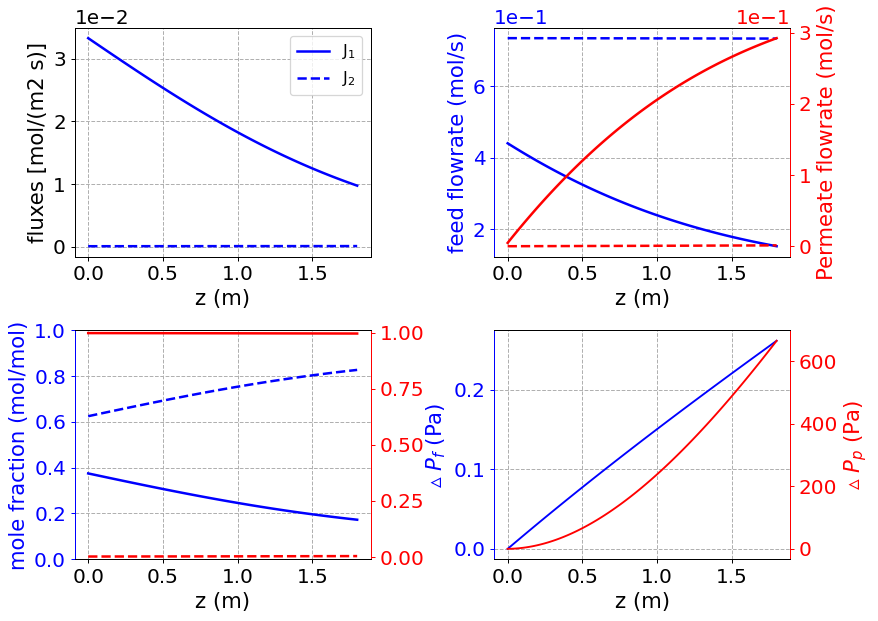

In [4]:
data = pd.read_csv('240221_Casestudy2_results.csv')
best_mof = data.sort_values(by='LCOH_opt').iloc[0,:]
a_H2, a_N2 = best_mof[['a_H2(mol/(mm^2 bar s))', 'a_N2(mol/(mm^2 bar s))']]
a_perm = np.array([a_H2, a_N2])
    
mem = MembraneProc(config, L, D_module, N_fiber, 
            n_component, n_node = N)
mem.membrane_info(a_perm, D_inner, D_outer)
mem.gas_prop_info(Mw_i, mu_i, rho_i)
mem.mass_trans_info(k_mass)
mem.boundaryC_info(y_feed, P_feed, F_feed, T)
mem.initialC_info()

res = mem.run_mem(cp=False, cp_cond = [1, 298])
err = mem.MassBalance()
mem.PlotResults()

In [5]:
# pySembrane results --> Aspen Plus
MemOut = MyStreams.Elements("MEMOUT").Elements("Input")
MemOut.Elements("FLOW").Elements("MIXED").Elements("HYDRO-01").Value = res[-1,2]*60*60*1e-3
MemOut.Elements("FLOW").Elements("MIXED").Elements("NITRO-01").Value = res[-1,3]*60*60*1e-3
MemOut.Elements("TEMP").Elements("MIXED").Value = T
MemOut.Elements("PRES").Elements("MIXED").Value = res[-1,-1]

sim.Run2()
sim.Save()

PureH2 = MyStreams.Elements("PUREH2").ElementS("Output").ElementS("RES_MASSFLOW").Value
print("Total H2 production: ", PureH2, "kg/hr")

Total H2 production:  15.0457283 kg/hr


## Sensitivity analysis

In [6]:
## Sensitivity analysis
conv_list = np.linspace(0.5, 0.95, 10)
H2_prod = []
for _conv in conv_list:

    Rxr = MyBlocks.Elements("R-200").Elements("Input").Elements("CONV").Elements("1")
    Rxr.Value = _conv

    sim.Run2()
    sim.Save()

    # Operating conditions
    P_feed = ProcOut.Elements("PRES_OUT").Elements("MIXED").Value  # pressure of feed side (bar)
    T = ProcOut.Elements("RES_TEMP").Value + 273.15
    F_feed = ProcOut.Elements("RES_MOLEFLOW").Value/60/60*1e3
    x_H2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("HYDRO-01").Value
    x_N2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("NITRO-01").Value
    y_feed = np.array([x_H2, x_N2])     # mole fraction (H2, N2)
    Ff_z0_init = list(y_feed*F_feed)

    mem.boundaryC_info(y_feed, P_feed, F_feed, T)
    mem.initialC_info()

    res = mem.run_mem(cp=False, cp_cond = [1, 298])
    err = mem.MassBalance()

    MemOut = MyStreams.Elements("MEMOUT").Elements("Input")
    MemOut.Elements("FLOW").Elements("MIXED").Elements("HYDRO-01").Value = res[-1,2]*60*60*1e-3
    MemOut.Elements("FLOW").Elements("MIXED").Elements("NITRO-01").Value = res[-1,3]*60*60*1e-3
    MemOut.Elements("TEMP").Elements("MIXED").Value = T-273.15
    MemOut.Elements("PRES").Elements("MIXED").Value = res[-1,-1]

    sim.Run2()
    sim.Save()

    PureH2 = MyStreams.Elements("PUREH2").ElementS("Output").ElementS("RES_MASSFLOW").Value
    H2_prod.append([F_feed, x_H2, x_N2, res[-1,0], res[-1,1], res[-1,2], res[-1,3], PureH2])
    print("Total H2 production: ", PureH2, "kg/hr")
    print("=========================================")

Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  8.68772466 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  9.50808426 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.4076339460819096e-14
Total H2 production:  10.3202323 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.899858223137475e-14
Total H2 production:  11.1244998 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  3.6227266850129113e-14
Total H2 production:  11.9213594 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  5.637281420850809e-14
Total H2 production:  12.7113538 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  13.4950477 kg/hr
Simulation started
Simulation is comp

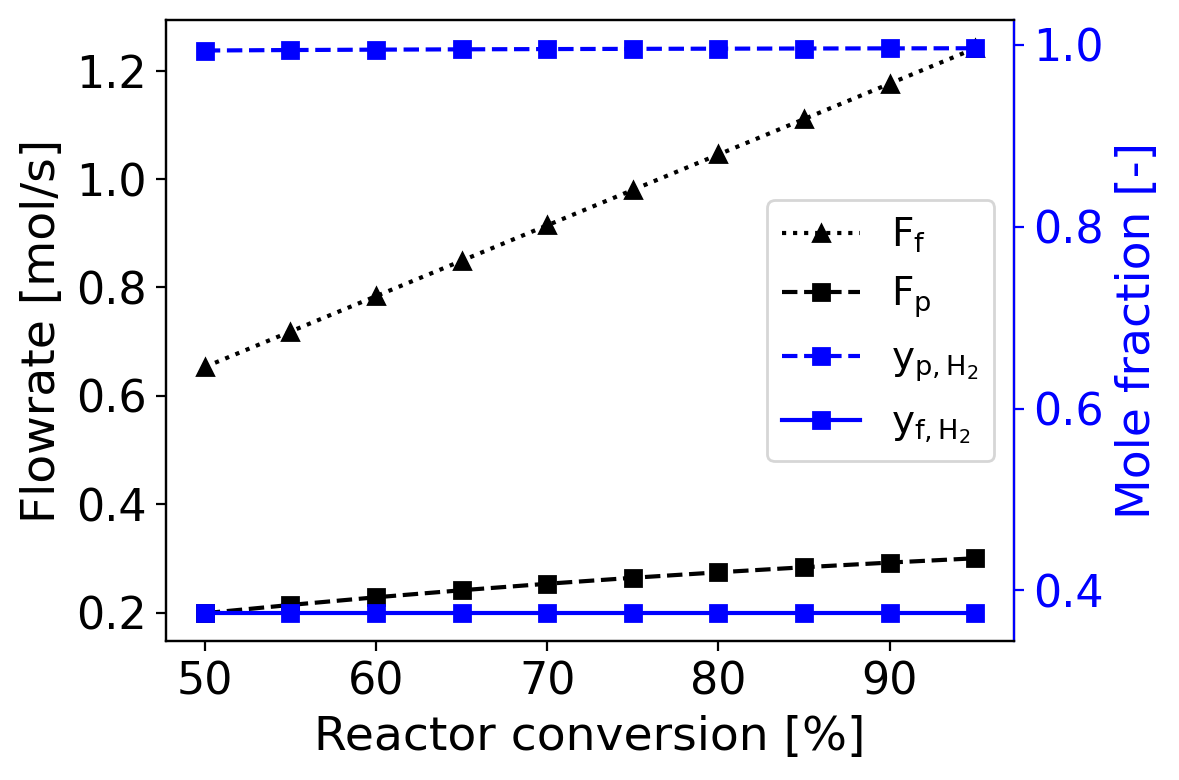

In [7]:
conv_nd = np.array(H2_prod)

fig, ax1= plt.subplots(dpi=200, figsize=(6,4))
line2 = ax1.plot(np.array(conv_list)*100, conv_nd[:,0], marker='^', c='k',
         label='F$\mathrm{_{f}}$', linestyle=':')
line7 = ax1.plot(np.array(conv_list)*100, conv_nd[:,5], marker='s', c='k',
         label='F$\mathrm{_{p}}$', linestyle='--')
ax1.set_ylabel('Flowrate [mol/s]')
ax2 = ax1.twinx()
line8 = ax2.plot(np.array(conv_list)*100,
                 conv_nd[:,1],
                 marker='s', c='b',
                 label='y$\mathrm{_{f,H_2}}$', linestyle='-')
line6 = ax2.plot(np.array(conv_list)*100, 
                 conv_nd[:,5]/conv_nd[:,5:7].sum(axis=1), 
                 marker='s', c='b',
                 label='y$\mathrm{_{p,H_2}}$', linestyle='--')
ax2.set_ylabel('Mole fraction [-]')
ax2.yaxis.label.set_color('b')
ax2.spines["right"].set_edgecolor('b')
ax2.tick_params(axis='y', colors='b')

plots = line2+line7+ line6+line8
labels = [l.get_label() for l in plots]
ax1.legend(plots, labels, loc='center right', fontsize=14)
ax1.set_xlabel('Reactor conversion [%]')
plt.tight_layout()
plt.show()

In [9]:
    ## Sensitivity analysis
    split_list = np.linspace(0.5, 0.95, 10)
    split_res = []
    for _split in split_list:

        Rxr = MyBlocks.Elements("PSA-400").Elements("Input").Elements("FRACS").Elements("401").Elements("MIXED").Elements("HYDRO-01")
        Rxr.Value = _split

        sim.Run2()
        sim.Save()

        # Operating conditions
        P_feed = ProcOut.Elements("PRES_OUT").Elements("MIXED").Value  # pressure of feed side (bar)
        T = ProcOut.Elements("RES_TEMP").Value + 273.15
        F_feed = ProcOut.Elements("RES_MOLEFLOW").Value/60/60*1e3
        x_H2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("HYDRO-01").Value
        x_N2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("NITRO-01").Value
        y_feed = np.array([x_H2, x_N2])     # mole fraction (H2, N2)
        Ff_z0_init = list(y_feed*F_feed)

        mem.boundaryC_info(y_feed, P_feed, F_feed, T)
        mem.initialC_info()

        res = mem.run_mem(cp=False, cp_cond = [1, 298])
        err = mem.MassBalance()

        MemOut = MyStreams.Elements("MEMOUT").Elements("Input")
        MemOut.Elements("FLOW").Elements("MIXED").Elements("HYDRO-01").Value = res[-1,2]*60*60*1e-3
        MemOut.Elements("FLOW").Elements("MIXED").Elements("NITRO-01").Value = res[-1,3]*60*60*1e-3
        MemOut.Elements("TEMP").Elements("MIXED").Value = T-273.15
        MemOut.Elements("PRES").Elements("MIXED").Value = res[-1,-1]

        sim.Run2()
        sim.Save()

        PureH2 = MyStreams.Elements("PUREH2").ElementS("Output").ElementS("RES_MASSFLOW").Value
        split_res.append([F_feed, x_H2, x_N2, res[-1,0], res[-1,1], res[-1,2], res[-1,3], PureH2])
        print("Total H2 production: ", PureH2, "kg/hr")
        print("=========================================")

Simulation started
Simulation is completed without warning
Mass balance (error %):  1.1398616802453514e-14
Total H2 production:  13.49597 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.2125624546006622e-14
Total H2 production:  13.9735771 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  2.5904240297559544e-14
Total H2 production:  14.4173822 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  2.7800268557923334e-14
Total H2 production:  14.8250341 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  2.9997520787601224e-14
Total H2 production:  15.1945238 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.628725139335379e-14
Total H2 production:  15.5243583 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  15.8137337 kg/hr


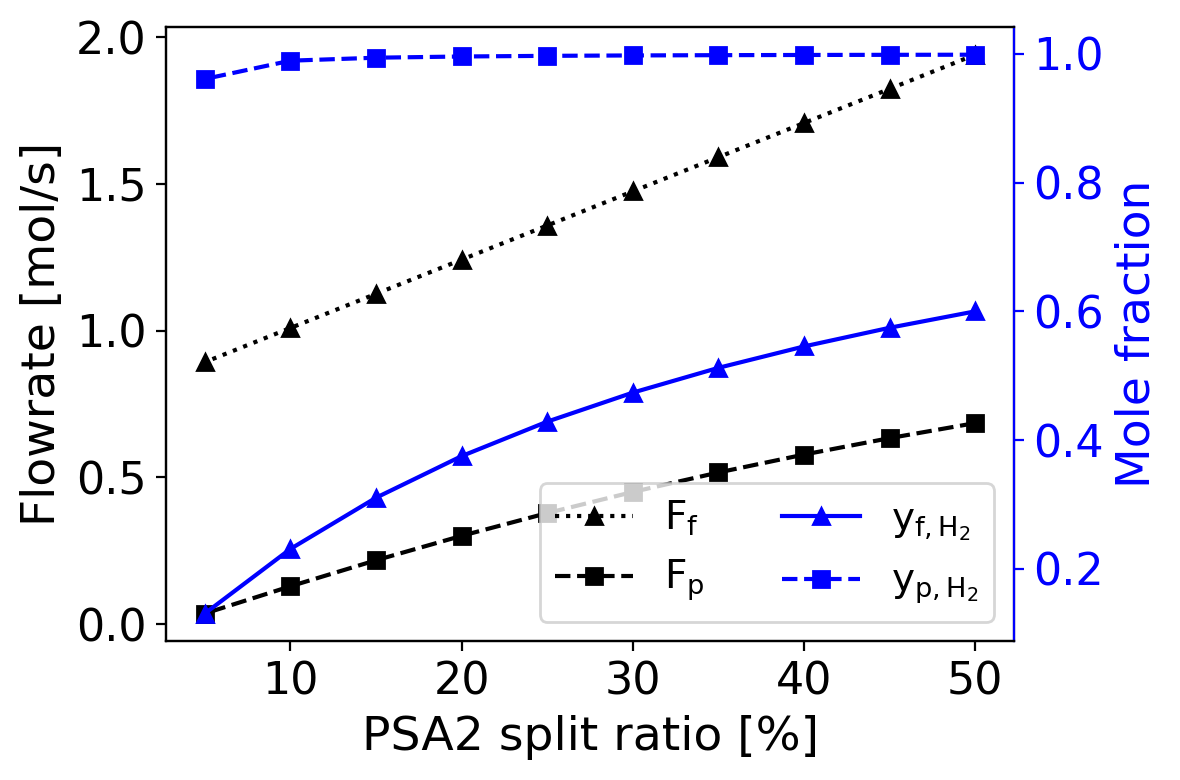

In [15]:
split_nd = np.array(split_res)

fig, ax1= plt.subplots(dpi=200, figsize=(6,4))
line2 = ax1.plot(100-np.array(split_list)*100, split_nd[:,0], marker='^', c='k',
         label='F$\mathrm{_{f}}$', linestyle=':')
line7 = ax1.plot(100-np.array(split_list)*100, split_nd[:,5], marker='s', c='k',
         label='F$\mathrm{_{p}}$', linestyle='--')
ax1.set_ylabel('Flowrate [mol/s]')
ax2 = ax1.twinx()
line3 = ax2.plot(100-np.array(split_list)*100, split_nd[:,1], marker='^', c='b',
         label='y$\mathrm{_{f,H_2}}$', )
line6 = ax2.plot(100-np.array(split_list)*100, 
                 split_nd[:,5]/split_nd[:,5:7].sum(axis=1), 
                 marker='s', c='b',
                 label='y$\mathrm{_{p,H_2}}$', linestyle='--')
ax2.set_ylabel('Mole fraction')
ax2.yaxis.label.set_color('b')
ax2.spines["right"].set_edgecolor('b')
ax2.tick_params(axis='y', colors='b')

plots = line2+line7+ line3+line6
labels = [l.get_label() for l in plots]
ax2.legend(plots, labels, loc='lower right', fontsize=14, ncol=2)
ax1.set_xlabel('PSA2 split ratio [%]' )
plt.tight_layout()
plt.show()

In [18]:
## Sensitivity analysis
nnn_list = np.linspace(100, 500, 5)
H2_prod = []
for nnn in nnn_list:

    Rxr = MyBlocks.Elements("R-200").Elements("Input").Elements("CONV").Elements("1")
    Rxr.Value = 0.9

    sim.Run2()
    sim.Save()

    # Operating conditions
    P_feed = ProcOut.Elements("PRES_OUT").Elements("MIXED").Value  # pressure of feed side (bar)
    T = ProcOut.Elements("RES_TEMP").Value + 273.15
    F_feed = ProcOut.Elements("RES_MOLEFLOW").Value/60/60*1e3
    x_H2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("HYDRO-01").Value
    x_N2 = ProcOut.Elements("MOLEFRAC").Elements("MIXED").Elements("NITRO-01").Value
    y_feed = np.array([x_H2, x_N2])     # mole fraction (H2, N2)
    Ff_z0_init = list(y_feed*F_feed)

    mem = MembraneProc(config, L, D_module, nnn, 
            n_component, n_node = N)
    mem.membrane_info(a_perm, D_inner, D_outer)
    mem.gas_prop_info(Mw_i, mu_i, rho_i)
    mem.mass_trans_info(k_mass)
    mem.boundaryC_info(y_feed, P_feed, F_feed, T)
    mem.initialC_info()

    res = mem.run_mem(cp=False, cp_cond = [1, 298])
    err = mem.MassBalance()

    MemOut = MyStreams.Elements("MEMOUT").Elements("Input")
    MemOut.Elements("FLOW").Elements("MIXED").Elements("HYDRO-01").Value = res[-1,2]*60*60*1e-3
    MemOut.Elements("FLOW").Elements("MIXED").Elements("NITRO-01").Value = res[-1,3]*60*60*1e-3
    MemOut.Elements("TEMP").Elements("MIXED").Value = T-273.15
    MemOut.Elements("PRES").Elements("MIXED").Value = res[-1,-1]

    sim.Run2()
    sim.Save()

    PureH2 = MyStreams.Elements("PUREH2").ElementS("Output").ElementS("RES_MASSFLOW").Value
    withoutMem = MyStreams.Elements("401").ElementS("Output").ElementS("RES_MASSFLOW").Value
    H2_prod.append([F_feed, x_H2, x_N2, res[-1,0], res[-1,1], res[-1,2], res[-1,3], PureH2, withoutMem])
    print("Total H2 production: ", PureH2, "kg/hr")
    print("=========================================")

Simulation started
Simulation is completed without warning
Mass balance (error %):  5.2495005386331944e-14
Total H2 production:  15.6010392 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  15.8073181 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Total H2 production:  15.9821993 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.3090533940644265e-14
Total H2 production:  16.1512123 kg/hr
Simulation started
Simulation is completed without warning
Mass balance (error %):  5.231798487339294e-14
Total H2 production:  16.3173747 kg/hr


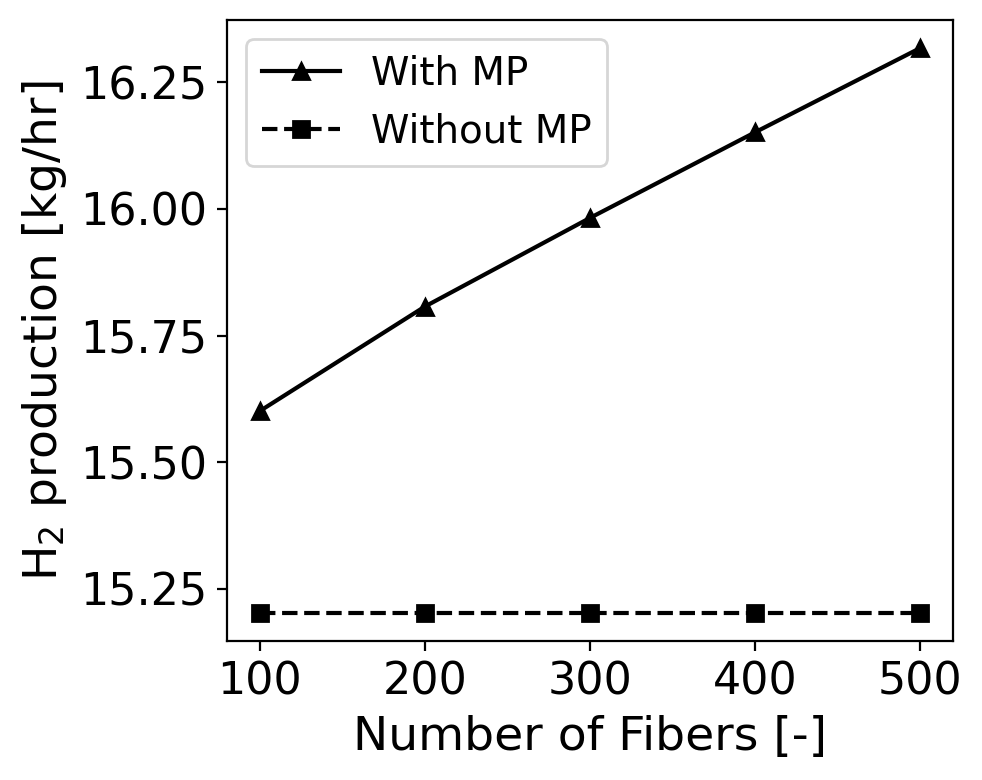

In [19]:
nnn_nd = np.array(H2_prod)

fig, ax1= plt.subplots(dpi=200, figsize=(5,4))
line2 = ax1.plot(np.array(nnn_list), nnn_nd[:,-2], marker='^', c='k',
         label='With MP', linestyle='-')
line7 = ax1.plot(np.array(nnn_list), nnn_nd[:,-1], marker='s', c='k',
         label='Without MP', linestyle='--')
ax1.set_ylabel('H$\mathrm{_2}$ production [kg/hr]')
plots = line2+line7+ line6+line8
labels = [l.get_label() for l in plots[:2]]
ax1.legend(plots, labels, loc='best', fontsize=14)
ax1.set_xlabel('Number of Fibers [-]')
plt.tight_layout()
plt.show()